# Identification of enhancers case study 

This section will present a comparative analysis to demonstrate the application and performance of proPythia for addressing sequence-based prediction problems.

We'll try to replicate one of the [BioSeq-Analysis](https://academic.oup.com/nar/article/47/20/e127/5559689?login=true) case studies for identifying [enhancers](https://academic.oup.com/bioinformatics/article/32/3/362/1744331?login=true#btv604-M1).

In [3]:
%load_ext autoreload

import sys
import numpy as np
import pandas as pd

from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier

sys.path.append('../../../../src/')
#from propythia.sequence import ReadSequence
#from propythia.descriptors import Descriptor
#from propythia.preprocess import Preprocess
from propythia.feature_selection import FeatureSelection
from propythia.shallow_ml import ShallowML
#from propythia.deep_ml import DeepML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This dataset has **742** weak enhancers, **742** strong enhancers, and **1484** non-enhancers.

In [4]:
strong_file =  r'enhancer_dataset/strong.fasta'
weak_file =  r'enhancer_dataset/weak.fasta'
non_file =  r'enhancer_dataset/non-enhancers.fasta.fasta'

# strong dataframe
strong = pd.read_csv(strong_file)
strong = strong.rename({'>': 'sequence'}, axis=1)
strong = strong[strong['sequence'] != '>']

# weak dataframe
weak = pd.read_csv(weak_file)
weak = weak.rename({'>': 'sequence'}, axis=1)
weak = weak[weak['sequence'] != '>']

# non dataframe
non = pd.read_csv(non_file)
non = non.rename({'>': 'sequence'}, axis=1)
non = non[non['sequence'] != '>']

print('strong', strong.shape)
print('weak', weak.shape)
print('non', non.shape)

KeyError: 'sequence'

In [4]:
# 1:3 ratio 
non_AMP_data_1_3 = non_AMP_data.sample(n=AMP_data.shape[0] * 3, replace=False)

To calculate features, and to be more easy, we create a function to calucalte features. Instead of calculating all available, we calculate all physicochemical features, AAC, DPC, PAAC, APAAC, CTD. For that we used the function adaptable from descriptors with numbers 19, 20, 21, 24, 26, 32 respectively. lamda were set to 4, as the minimal seq len is 5. 

In [5]:

# calculate features
def calculate_feature(data):
    list_feature = []
    for seq in data['sequence']:
        res = {'sequence': seq}
        sequence = ReadSequence()  # creating sequence object
        ps = sequence.read_protein_sequence(seq)
        protein = Descriptor(ps)  # creating object to calculate descriptors
        feature = protein.adaptable([19, 20, 21, 24, 26, 32], lamda_paac=4, lamda_apaac=4)
        # feature = protein.get_all(lamda_paac=5, lamda_apaac=5) #minimal seq len = 5
        # lambda should not be larger than len(sequence)
        res.update(feature)
        list_feature.append(res)
    print('saving features')
    df = pd.DataFrame(list_feature)
    return df


amp_feature = calculate_feature(AMP_data)
no_amp_feature = calculate_feature(non_AMP_data_1_3)


saving features


In [6]:
# amp_feature['label'] = 1
no_amp_feature['label'] = 0

# print(amp_feature.shape)
print(no_amp_feature.shape)

# amp_feature.to_csv('datasets/ampep_feat.csv', index = False)
no_amp_feature.to_csv('datasets/no_ampep_feat.csv', index = False)

(9804, 642)


If you want to calculate features and as the large data take some time, we store in a file to ease someone that wants to run this jupyter. The negative dataset is complete (not 1:3) The files are stored in:

AMP_data = 'datasets/ampep_feat.csv'

non_AMP_non_AMP = 'datasets/non_ampep_feat.csv'
<!-- AMP_data = pd.read_csv('datasets/ampep_feat.csv')
AMP_data['label'] = 1
non_AMP_data_1_3 = pd.read_csv('datasets/non_ampep_feat.csv')
non_AMP_data_1_3['label'] = 0

dataset = pd.concat([AMP_data, non_AMP_data_1_3]) -->


In [2]:
amp_feature = pd.read_csv('datasets/ampep_feat.csv', low_memory = False)
no_amp_feature = pd.read_csv('datasets/no_ampep_feat.csv', low_memory = False)
amp_feature['label'] = 1
no_amp_feature['label'] = 0

print(amp_feature.shape)
print(no_amp_feature.shape)
amp_feature

(3268, 642)
(9804, 642)


sequence  lenght  charge  \
0              AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC    40.0   4.790   
1     AAEFPDFYDSEEQMGPHQEAEDEKDRADQRVLTEEEKKELENLAAM...    60.0 -10.886   
2     AAFFAQQKGLPTQQQNQVSPKAVSMIVNLEGCVRNPYKCPADVWTN...   169.0   7.697   
3                                     AAFRGCWTKNYSPKPCL    17.0   2.860   
4                                            AAGMGFFGAR    10.0   0.996   
...                                                 ...     ...     ...   
3263                                    YIRDFITRRPPFGNI    15.0   1.996   
3264                                         GILDALTGIL    10.0  -1.004   
3265                                      IFKAIWSGIKRLC    13.0   2.928   
3266                                      ILGKFCDEIKRIV    13.0   0.930   
3267                                      ILSYLWNGIKSIF    13.0   0.995   

      chargedensity  formulaC  formulaH  formulaN  formulaO  formulaS   tot  \
0          0.001113       176       290        60        54         6   739   
1         -0.001542       297       455        77       114         2  1089   
2          0.000408       808      1281       231       261        10  3062   
3          0.001473        88       132        24        22         2   329   
4          0.001012        44        65        13        11         1   153   
...             ...       ...       ...       ...       ...       ...   ...   
3263       0.001070        87       133        25        21         0   298   
3264      -0.001019        45        80        10        14         0   166   
3265       0.001908        73       119        19        15         1   265   
3266       0.000606        70       120        18        18         1   263   
3267       0.000640        77       116        16        18         0   254   

      ...  _HydrophobicityD2025  _HydrophobicityD2050  _HydrophobicityD2075  \
0     ...                26.667                66.667               153.333   
1     ...                33.333               106.667               220.000   
2     ...                67.273               150.909               214.545   
3     ...                25.000               100.000               150.000   
4     ...                16.667                50.000                83.333   
...   ...                   ...                   ...                   ...   
3263  ...                20.000               140.000               200.000   
3264  ...                25.000               125.000               175.000   
3265  ...               266.667               133.333               233.333   
3266  ...               300.000               300.000               300.000   
3267  ...                75.000               100.000               200.000   

      _HydrophobicityD2100  _HydrophobicityD3001  _HydrophobicityD3025  \
0                  253.333                25.000               100.000   
1                  386.667                33.333               116.667   
2                  305.455                 6.250                81.250   
3                  187.500                60.000                60.000   
4                  150.000               133.333               233.333   
...                    ...                   ...                   ...   
3263               260.000                40.000                40.000   
3264               200.000                40.000                40.000   
3265               266.667                14.286                14.286   
3266               300.000                14.286                14.286   
3267               275.000                14.286                14.286   

      _HydrophobicityD3050  _HydrophobicityD3075  _HydrophobicityD3100  label  
0                  158.333               275.000               333.333      1  
1                  333.333               400.000               475.000      1  
2                  166.667               279.167               347.917      1  
3                  120.000             

 1 - MIMIC AMPEP MODEL  
ratio 1:3  Feature D Dfrom CTD feature)
RF  CV = 10 
No reference to scaling
define parameters as the article
In the article AMPEP suggests that tested 100 200 and 500 estimators with 100 being the best
Besides the article did not clarify which measure they use. here we optimize MCC 


In [4]:
dataset = pd.concat([amp_feature, no_amp_feature])

fps_y = dataset['label']
fps_x = dataset.loc[:, dataset.columns != 'label']
fps_x = fps_x.filter(regex=r'_.+D\d', axis=1)  # select just CTD D feature 105 columns
print(fps_x.shape)

(13072, 105)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(fps_x, fps_y, stratify=fps_y)

# standard scaler article does not refer scaling and do not validate in x_test, however, we do it anyway
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# open a ShallowML object
ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=fps_x.columns)
#define param grid as article, here we will search in 100, 200 and 500 estimators
param_grid = [{'clf__n_estimators': [100, 200, 500], 'clf__max_features': ['sqrt']}]
# train_best_model will perform a GRIDSEARCHCV optimizing MCC with a cv = 10
best_rf_model_AMPEP = ml.train_best_model('rf', score=make_scorer(matthews_corrcoef), param_grid=param_grid, cv=10)

performing gridSearch...
GridSearchCV took 57.31 seconds for 3 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=10,
             param_grid=[{'clf__max_features': ['sqrt'],
                          'clf__n_estimators': [100, 200, 500]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.895 (std: 0.010)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 100}
 

Model with rank: 2
 Mean validation score: 0.894 (std: 0.009)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 500}
 

Model with rank: 3
 Mean validation score: 0.893 (std: 0.009)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 200}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters 

In [13]:
#get the scores for testset
scores, report, cm, cm2 = ml.score_testset(best_rf_model_AMPEP)
print(report)
print(cm)
scores

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2451
           1       0.90      0.94      0.92       817

    accuracy                           0.96      3268
   macro avg       0.94      0.96      0.95      3268
weighted avg       0.96      0.96      0.96      3268

[[2369   82]
 [  45  772]]


{'Accuracy': 0.9611383108935129,
 'MCC': 0.8983073915294071,
 'log_loss': 0.15159210054214592,
 'f1 score': 0.9239976062238181,
 'roc_auc': 0.9557323541411671,
 'Precision': array([0.25      , 0.90398126, 1.        ]),
 'Recall': array([1.        , 0.94492044, 0.        ]),
 'fdr': 0.09601873536299765,
 'sn': 0.944920440636475,
 'sp': 0.9665442676458589}

As expressed in the AmPEP paper, 100 estimators is the model performing better. However, this difference is small and sometimes may change (RF are not stochastic).

To mimic the model, we run a cross validation model with all data (no train/test data). We define specificity and sensitivity outside the function, to replicate the metrics used in AmPEP. 

In [20]:
# multiple metrics
def sp(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fdr = float(fp) / (tp + fp)
    sn = float(tp) / (tp + fn)
    sp = float(tn) / (tn + fp)
    return sp


def sn(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fdr = float(fp) / (tp + fp)
    sn = float(tp) / (tp + fn)
    sp = float(tn) / (tn + fp)
    return sn

#define multiple metrcs to evaluate cross validation
scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'MCC': make_scorer(matthews_corrcoef),
           'sn': make_scorer(sn), 'sp': make_scorer(sp)}

#scaling the data. here, we will use all the data, and not divide in train and test set
scaler_d = StandardScaler().fit_transform(fps_x)

ml = ShallowML(x_train=scaler_d, x_test=None, y_train=fps_y, y_test=None, report_name=None, columns_names=fps_x.columns)
scores = ml.cross_val_score_model('rf', score=scoring, n_estimators=100, max_features='sqrt', cv=10, random_state=65)
pd.DataFrame(scores)

performing cross val score with 10 folds


fit_time  score_time  test_AUC  test_Accuracy  test_MCC   test_sn  \
0     7.686920    0.042343  0.985179       0.951835  0.871967  0.908257   
1     7.689360    0.041712  0.989340       0.955657  0.882263  0.917431   
2     7.802144    0.041589  0.986569       0.953328  0.881522  0.957187   
3     7.792178    0.042337  0.993024       0.966335  0.913119  0.966361   
4     7.667900    0.041621  0.990757       0.954858  0.883765  0.948012   
5     8.043298    0.041792  0.980127       0.915073  0.765997  0.755352   
6     6.491632    0.038717  0.941267       0.899770  0.720620  0.678899   
7     7.591667    0.041860  0.987839       0.955624  0.881489  0.908257   
8     7.751979    0.041764  0.983207       0.941852  0.842578  0.858896   
9     7.639054    0.041717  0.968181       0.936496  0.827464  0.840491   
mean  7.615613    0.041545  0.980549       0.943083  0.847078  0.873914   
std   0.393090    0.000977  0.014667       0.019702  0.057364  0.088687   

       test_sp  
0     0.966361  
1     0.968400  
2     0.952041  
3     0.966327  
4     0.957143  
5     0.968367  
6     0.973469  
7     0.971429  
8     0.969419  
9     0.968400  
mean  0.966135  
std   0.006224

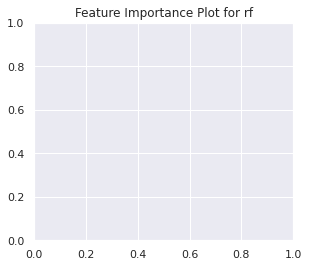

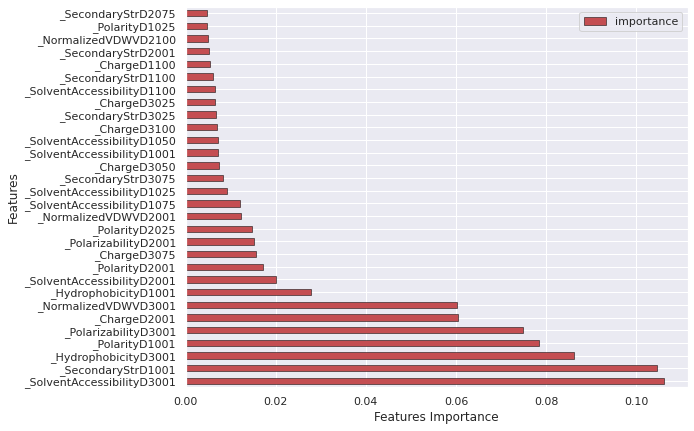

<Figure size 432x288 with 0 Axes>

In [21]:
df = ml.features_importances_df(classifier=best_rf_model_AMPEP, model_name='rf', top_features=30,
                                column_to_sort='mean_coef')
ml.features_importances_plot(classifier=best_rf_model_AMPEP, top_features=30, model_name='rf',
                             column_to_plot=None,
                             show=True, path_save=None,
                             title=None,
                             kind='barh', figsize=(9, 7), color='r', edgecolor='black')
# df[:30]

In the figure above is possible to see the Feature importance with hidrophobicity D3001 the most important. Hydrophobic of group 3 (gydrophobic - CLVIMFW) in the first position.  The top features are related with the first position of aminoacids. 

 2 - Using a dataset with all physicochemical features (and not only D feature from CTD) we perform a hyperparameter optimization using GridSearch CV with 10. The grid parameters are the ones defaulted in package. 
 2.1 SVM GridSearchCV
 2.2 RF GridSearchCV
 2.3 Simple DNN 

The first part is to take from the dataset, columns that are invariante or filled with zeros, preprocessing the dataset. 
The next step is to divide this in train test and standard scale it. 


In [2]:
AMP_data = pd.read_csv('datasets/ampep_feat_complete.csv')
AMP_data = AMP_data.drop({'Unnamed: 0'}, axis=1)
AMP_data['label'] = 1
non_AMP_data_1_3 = pd.read_csv('datasets/non_ampep_feat_complete.csv')
non_AMP_data_1_3['label'] = 0

dataset = pd.concat([AMP_data, non_AMP_data_1_3])  # (13072, 642)

fps_y = dataset['label']
fps_x = dataset.drop(['label', 'sequence'], axis=1)
#  Preprocess
prepro = Preprocess()  # Create Preprocess object
fps_x_clean, columns_deleted = prepro.preprocess(fps_x, columns_names=True, threshold=0,
                                                 standard=True)  # [13072 rows x 628 columns]
X_train, X_test, y_train, y_test = train_test_split(fps_x_clean, fps_y, stratify=fps_y)
# standard scaler article does not refer scaling and do not validate in x_test
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=fps_x_clean.columns)

best_svm_model_AMPEP = ml.train_best_model('svm', score=make_scorer(matthews_corrcoef), param_grid=None, cv=10)
scores, report, cm, cm2 = ml.score_testset(best_svm_model_AMPEP)
scores

performing gridSearch...
GridSearchCV took 843.60 seconds for 16 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', SVC(random_state=1))]),
             n_jobs=10,
             param_grid=[{'clf__C': [0.01, 0.1, 1.0, 10],
                          'clf__kernel': ['linear']},
                         {'clf__C': [0.01, 0.1, 1.0, 10],
                          'clf__gamma': ['scale', 0.001, 0.0001],
                          'clf__kernel': ['rbf']}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.882 (std: 0.021)
 Parameters: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
 

Model with rank: 2
 Mean validation score: 0.881 (std: 0.019)
 Parameters: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
 

Model with rank: 3
 Mean validation score: 0.869 (std: 0.019)
 Parameters: {'clf__C': 1.0, 'clf__gamma': 'scale', 'clf__k

{'Accuracy': 0.9648102815177478,
 'MCC': 0.9072932514349055,
 'f1 score': 0.9306811332127788,
 'roc_auc': 0.9581803345573235,
 'Precision': array([0.25      , 0.91686461, 1.        ]),
 'Recall': array([1.        , 0.94492044, 0.        ]),
 'fdr': 0.0831353919239905,
 'sn': 0.944920440636475,
 'sp': 0.9714402284781721}

In [38]:
ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=fps_x_clean.columns)
param_grid={'clf__C':[10], 'clf__gamma':[0.001], 'clf__kernel':['rbf']}
best_svm_model = ml.train_best_model('svm', score=make_scorer(matthews_corrcoef), param_grid=param_grid, cv=10)
scores, report, cm, cm2 = ml.score_testset(best_svm_model)
scores

performing gridSearch...
GridSearchCV took 40.96 seconds for 1 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', SVC(random_state=1))]),
             n_jobs=10,
             param_grid={'clf__C': [10], 'clf__gamma': [0.001],
                         'clf__kernel': ['rbf']},
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.882 (std: 0.021)
 Parameters: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 10-fold cross validation:
 MCC score:	0.882
 Parameters:	{'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}

0.882245 (0.020517) with: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
   clf__C  clf__gamma clf__kernel     means      stds
0      10       0.001         rbf  0.882245  0.020517


{'Accuracy': 0.9648102815177478,
 'MCC': 0.9072932514349055,
 'f1 score': 0.9306811332127788,
 'roc_auc': 0.9581803345573235,
 'Precision': array([0.25      , 0.91686461, 1.        ]),
 'Recall': array([1.        , 0.94492044, 0.        ]),
 'fdr': 0.0831353919239905,
 'sn': 0.944920440636475,
 'sp': 0.9714402284781721}

the kernel RBF does not support feature importance analysis

In [43]:
ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=fps_x_clean.columns)

best_rf_model = ml.train_best_model('rf', score=make_scorer(matthews_corrcoef), param_grid=None, cv=10)
scores, report, cm, cm2 = ml.score_testset(best_rf_model)
scores

performing gridSearch...
GridSearchCV took 137.76 seconds for 6 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=10,
             param_grid=[{'clf__bootstrap': [True], 'clf__criterion': ['gini'],
                          'clf__max_features': ['sqrt', 'log2'],
                          'clf__n_estimators': [10, 100, 500]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.898 (std: 0.023)
 Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 500}
 

Model with rank: 2
 Mean validation score: 0.898 (std: 0.019)
 Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}
 

Model with rank: 3
 Mean validation score: 0.88

{'Accuracy': 0.9678702570379437,
 'MCC': 0.9157822505082389,
 'log_loss': 0.10073497360157636,
 'f1 score': 0.9370125974805039,
 'roc_auc': 0.9638922888616892,
 'Precision': array([0.25      , 0.91882353, 1.        ]),
 'Recall': array([1.        , 0.95593635, 0.        ]),
 'fdr': 0.0811764705882353,
 'sn': 0.95593635250918,
 'sp': 0.9718482252141983}

run features importances. 
the top 4 features in the model constructed using full set of descriptors are from the set of D descriptors, which can explain why using only D descriptors obtained good results. These descriptors characterize the distribution patterns of
amino acids of each class in the sequence. It represents the position percentages in the whole sequence for the first residue, 25% residues, 50% residues, 75% residues and 100% residues for a specific encoded class. 
Top features from this set, common to both models, include the SolventAccessibilityD3001, HydrophobicityD3001, PolarizabilityD3001, PolarityD1001 , SecondaryStrD1001, and ChargeD2001. Furthermore, other important features include molecular weight, number of H, N, C and O and AAc and PAAC. 

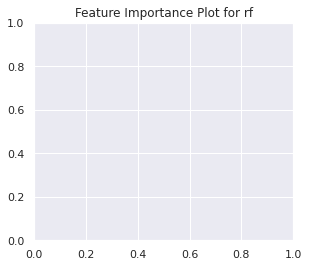

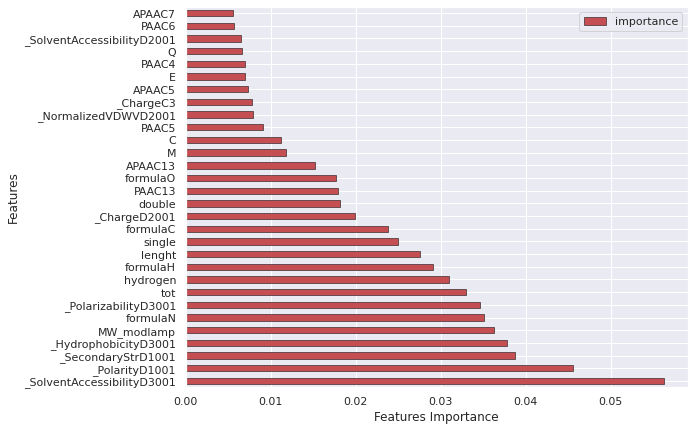

                            importance
_SolventAccessibilityD3001    0.056236
_PolarityD1001                0.045552
_SecondaryStrD1001            0.038689
_HydrophobicityD3001          0.037756
MW_modlamp                    0.036216
formulaN                      0.035109
_PolarizabilityD3001          0.034589
tot                           0.033024
hydrogen                      0.030940
formulaH                      0.029046
lenght                        0.027579
single                        0.024986
formulaC                      0.023760
_ChargeD2001                  0.019875
double                        0.018131
PAAC13                        0.017926
formulaO                      0.017664
APAAC13                       0.015273
M                             0.011826
C                             0.011270
PAAC5                         0.009111
_NormalizedVDWVD2001          0.007940
_ChargeC3                     0.007835
APAAC5                        0.007332
E                        

<Figure size 432x288 with 0 Axes>

In [44]:
df = ml.features_importances_df(classifier=best_rf_model, model_name='rf', top_features=30, column_to_sort=None)
plot = ml.features_importances_plot(classifier=best_rf_model, top_features=30, model_name='rf',
                             column_to_plot=None,
                             show=True, path_save='',
                             title=None,
                             kind='barh', figsize=(9, 7), color='r', edgecolor='black')
print(df[:30])

To test if a DL model would perform better, we ran a simple DNN, optimizing parameters with randomized search: 
the number of layers, the units in each hidden layer, the dropout rate, and the L1 and L2 regularization parameters.
The best model was obtained by using L1 with its parameter having a value of 0.0001, one hidden layer with 64 units and a dropout rate of 0.35. This model obtained an accuracy of 0.96 and MCC of 0.89

dnn model simple
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarIsInitializedOp in devi

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op AnonymousIteratorV2 in device /job:localhost/re

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_112681 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 6ms/step - loss: 1.2520 - accuracy: 0.6129
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_136835 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 1ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandle

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/d

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_300683 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exec

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_318839 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMap

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executi

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/d

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:G

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_522301 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 7ms/step - loss: 1.3853 - accuracy: 0.7059
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Ex

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_546455 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMap

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:G

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_673991 in device /job:localho

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_692147 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Rep

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op 

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_854395 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 6ms/step - loss: 0.8017 - accuracy: 0.7199
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_872551 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 6ms/step - loss: 0.8720 - accuracy: 0.6880
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_982643 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:loca

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
E

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_1105707 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 5ms/step - loss: 0.5318 - accuracy: 0.7856
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_1133139 in device /job:localh

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_1150783 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Re

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op 

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_1290779 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 6ms/step - loss: 4.4634 - accuracy: 0.8636
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_1308423 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 6ms/step - loss: 4.5069 - accuracy: 0.8232
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_1418515 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:loca

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
E

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_1558209 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 7ms/step - loss: 5.2861 - accuracy: 0.6228
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
E

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_1582363 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMa

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:G

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_1761927 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 7ms/step - loss: 0.5439 - accuracy: 0.7756
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
E

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_1785313 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMa

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:G

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_2004865 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 5ms/step - loss: 0.5388 - accuracy: 0.7733
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exec

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_2032329 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

18/18 [==============================] - 0s 5ms/step - loss: 0.5253 - accuracy: 0.7733
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_2072079 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDa

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/devi

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_2253179 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 7ms/step - loss: 0.9986 - accuracy: 0.6961
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
E

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_2277333 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMa

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_2316627 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 6ms/step - loss: 0.9278 - accuracy: 0.8096
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_2334271 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 6ms/step - loss: 0.9636 - accuracy: 0.7802
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/devic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_2441291 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:loca

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
E

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_2543065 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 5ms/step - loss: 0.5421 - accuracy: 0.7858
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_2571009 in device /job:localh

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op __inference_train_function_2583535 in device /job:localhost/replica:0/task:0/device:GPU:0
18/18 [==============================] - 0s 5ms/step - loss: 0.5123 - accuracy: 0.8000
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/devic

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_predict_function_2611479 in device /job:localhost/replica:0/task:0/device:GPU:0
2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Re

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

2/2 [==============================] - 0s 2ms/step
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:loca

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
E

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:

Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op __inference_train_function_2756265 in device /job:localhost/replica:0/task:0/device:GPU:0
20/20 [==============================] - 0s 5ms/step - loss: 0.4766 - accuracy: 0.8052
RandomizedSearchCV took 1680.39 seconds for 15 candidates parameter settings.
RandomizedSearchCV(cv=10,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4fb0bda820>,
                   n_iter=1

Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/re

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op VarHandleOp in device /job:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2770317 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/devi

18/18 [==============================] - 0s 17ms/step - loss: 0.2355 - accuracy: 0.9413 - val_loss: 0.2486 - val_accuracy: 0.9419 - lr: 0.0010
Epoch 4/500
11/18 [=================>............] - ETA: 0s - loss: 0.2034 - accuracy: 0.9496Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset 

Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
18/18 [==============================] - 0s 18ms/step - loss: 0.0717 - 

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/ta

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
18/18 [==============================] - 0s 16ms/step - loss: 0.0513 - accuracy: 0.9880 - val_loss: 0.1490 - val_accuracy: 0.9501 - lr: 0.0010
Epoch 23/500
11/18 [=================>............] - ETA: 0s - loss: 0.0431 - accuracy: 0.9924Ex

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executi

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/tas

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
18/18 [==============================] - 0s 16ms/step - loss: 0.0358 - accuracy: 0.9933 - val_loss: 0.1541 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 30/500
11/18 [=================>............] - ETA: 0s - loss: 0.0372 - accuracy: 0.9927Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Exec

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
18/18 [==============================] - 0s 16ms/step - loss: 0.0314 - accuracy: 0.9952 - val_loss: 0.1542 - val_accuracy: 0.9541 - lr: 0.0010
Epoch 37/500
11/18 [=================>............] - ETA: 0s - loss: 0.0289 - accuracy: 0.9957Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op F

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
18/18 [==============================] - 0s 16ms/step - loss: 0.0291 - accuracy: 0.9944 - val_loss: 0.1614 - val_accuracy: 0.9572 - lr: 0.0010
Epoch 44/500
11/18 [=================>............] - ETA: 0s - loss: 0.0283 - accuracy: 0.9956Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Repea

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:4
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:5
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
18/18 [==============================] - 0s 16ms/step - loss: 0.0285 - accuracy: 0.9949 - val_loss: 0.1756 - val_accuracy: 0.9551 - lr: 0.0010
Epoch 00050: early stopping
('Training Accuracy mean: ', 0.9801292133331299) 
 ('Validation Accuracy mean: ', 0.9492966377735138) 
 ('Training Loss mean: ', 0.0772391838952899) 
 ('Validation Loss mean: ', 0.16982029020786285)
Model: "sequential_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_462 (Dense)            (None, 64)                40256     
_________________________________________________________________
batch_normalization_311 (Bat (None, 64)                256       
_________________________________________________________________
dropout_311 (Dropout)        (None, 64)                0         
____________________________________________________________

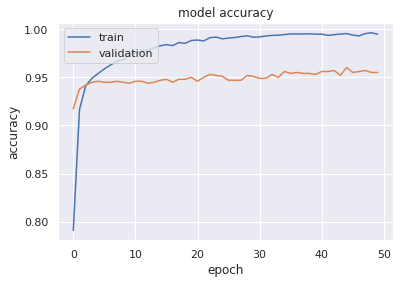

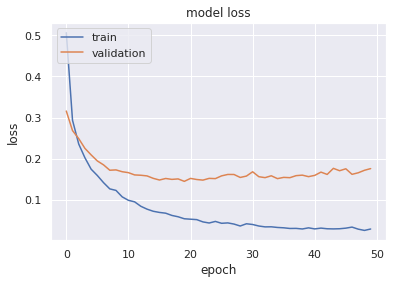

[['Model with rank: 1\n', 'Mean validation score: 0.784 (std: 0.036)\n', "Parameters: {'l2': 0.0001, 'l1': 0, 'hidden_layers': (64,), 'dropout_rate': 0.2}\n", '\n'], ['Model with rank: 2\n', 'Mean validation score: 0.779 (std: 0.028)\n', "Parameters: {'l2': 0.001, 'l1': 0, 'hidden_layers': (64,), 'dropout_rate': 0.25}\n", '\n'], ['Model with rank: 3\n', 'Mean validation score: 0.758 (std: 0.047)\n', "Parameters: {'l2': 0, 'l1': 1e-05, 'hidden_layers': (64,), 'dropout_rate': 0.25}\n", '\n']]
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 10-fold cross validation:

df
       means      stds       l2       l1  hidden_layers  dropout_rate
10  0.783685  0.036384  0.00010  0.00000          (64,)          0.20
14  0.778973  0.027940  0.00100  0.00000          (64,)          0.25
5   0.758308  0.046547  0.00000  0.00001          (64,)          0.25
13  0.727198  0.050501  0.00010  0.00001          (64,)          0.35
7   0.651768  0.038770  0.00001  0.00001       (64

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:6
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:7
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:7
7/7 [==============================] - 0s 2ms/step


{'Accuracy': 0.9593023255813954,
 'MCC': 0.8924133096001624,
 'log_loss': 0.20360471681209277,
 'f1 score': 0.9195402298850575,
 'roc_auc': 0.9496124031007751,
 'Precision': array([0.25      , 0.90909091, 1.        ]),
 'Recall': array([1.        , 0.93023256, 0.        ]),
 'sn': 0.9302325581395349,
 'sp': 0.9689922480620154}

<Figure size 432x288 with 0 Axes>

In [3]:
dl = DeepML(X_train, y_train, X_test, y_test, number_classes=2, problem_type='binary',
            x_dval=None, y_dval=None, epochs=500, batch_size=512,
            path='', report_name=None, verbose=1)

#hyperparameter optimization dnn
dnn = dl.run_dnn_simple(
    input_dim=X_train.shape[1],
    optimizer='Adam',
    hidden_layers=(128, 64),
    dropout_rate=(0.3,),
    batchnormalization=(True,),
    l1=1e-5, l2=1e-4,
    final_dropout_value=0.3,
    initial_dropout_value=0.0,
    loss_fun=None, activation_fun=None,
    cv=10, optType='randomizedSearch', param_grid=None, n_iter_search=15, n_jobs=1,
    scoring=make_scorer(matthews_corrcoef))
scores, report, cm, cm2 = dl.model_complete_evaluate()
scores